In [1]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
from matplotlib import rc
import matplotlib.pyplot as plt
import datetime
import math
import logging
import stock_cache # local module
#%matplotlib inline

# pandas, plt setting
pd.set_option('display.expand_frame_repr', False)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG,
    handlers=[
        logging.FileHandler("backtest.log"),
        logging.StreamHandler()
    ])
log = logging.getLogger()

# fdr
fdr.__version__

# constant
MOMENTUM_DAYS = 180 # 6개월
now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정

In [27]:
ticker_dict_10 = {
    "005930.KS": { "stock_name": "Samsung", "data": pd.DataFrame() },
    "000660.KS": { "stock_name": "SK Hynix", "data": pd.DataFrame() },
    "051910.KS": { "stock_name": "LG화학", "data": pd.DataFrame() },
    "068270.KS": { "stock_name": "셀트리온", "data": pd.DataFrame() },
    "035420.KS": { "stock_name": "Naver", "data": pd.DataFrame() },
    "006400.KS": { "stock_name": "Samsung SDI", "data": pd.DataFrame() },
    "005380.KS": { "stock_name": "Hyundai", "data": pd.DataFrame() },
    "035720.KS": { "stock_name": "Kakao", "data": pd.DataFrame() },
    "036570.KS": { "stock_name": "NCsoft", "data": pd.DataFrame() },
    "051900.KS": { "stock_name": "LG생활건강", "data": pd.DataFrame() }
}

std_dict = { }
ticker_dict = { }

# 테스트 코드

## Dictionary append

In [214]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

005930.KS {'code': '005930.KS', 'name': 'Samsung'}


## DataFrame append

In [215]:
dates = pd.date_range("20130101", periods=6)
print(type(dates[0]))
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


# 종목 정보 가져오기

In [3]:
# DataFrame
#def get_rate_of_return(x):
#    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100
    
def get_ticker_data(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    prev_len = len(prev_data)
    if (prev_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print(f"get_ticker_data(): ticker_data not enough: code={code} prev_len={prev_len}")
        return pd.DataFrame()
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    ticker_len = len(ticker_data)
    if (ticker_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print(f"get_ticker_data(): ticker_data not enough: code={code} ticker_len={ticker_len}")
        return pd.DataFrame()
    total_data = pd.concat([prev_data, ticker_data])

    # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
    start_loc = len(prev_data)-1
    prev_data01 = total_data[start_loc:start_loc+len(ticker_data)]
    prev_data180 = total_data[:len(ticker_data)]
    ticker_data['prev_close01'] = prev_data01['Close'].values
    ticker_data['prev_close180'] = prev_data180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.round(2).values # prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[prev_len:]
    ticker_data['ma25'] = ma25[prev_len:]
    ticker_data['ma50'] = ma50[prev_len:]
    ticker_data['ma100'] = ma100[prev_len:]
    
    # ATR(Average Trace Range) 추가
    tr = total_data['High'] - total_data['Low']
    ticker_data['tr'] = tr[prev_len:]
    atr20 = tr.rolling(window=20).mean()
    ticker_data['atr20'] = atr20[prev_len:]
    
    # ATA(Average Trading Amount-총거래액) 추가
    ta = total_data['Close'] * total_data['Volume']
    ticker_data['ta'] = ta[prev_len:]
    ata20 = ta.rolling(window=20).mean()
    ticker_data['ata20'] = ata20[prev_len:]
    
    return ticker_data

# cache 이용하지 않고 직접 호출(미사용이며 참고용)
def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_dict.items():
        name = v['stock_name']
        std_data = v['data']
        subplot.plot(std_data['relative_value'], label=name)
        subplot.legend()

    for k, v in ticker_dict.items():
        if (k in ["005930.KS"]):
            name = v['stock_name']
            ticker_data = v['data']
            subplot.plot(ticker_data['relative_value'], label=name)
            subplot.legend()

    #for k, v in system_dict.items():
    #    if (k in ["LTHM"]):
    #        name = v['name']
    #        system_data = v['data']
    #        subplot.plot(system_data['relative_value'], label=name)
    #        subplot.legend()
    ##plt.show()
    #return subplot
            
    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [30]:
def reset_dict():
    global std_dict
    global ticker_dict
    std_dict = { 
        "KS11": { "stock_name": "KOSPI", "data": pd.DataFrame() },
        "KS200": { "stock_name": "KOSPI200", "data": pd.DataFrame() }
    }

    #ticker_exclude_list = ["105560.KS"] # "105560.KS" KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대
    #ticker_dict = stock_cache.get_stock_listing_dict(1000, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기
    #print("ticker_dict len =", len(ticker_dict))
    
    ticker_dict = {
        "005930.KS": { "stock_name": "Samsung", "data": pd.DataFrame() },
        "102110.KS": { "stock_name": "Tiger 200", "data": pd.DataFrame() },
        "SPY": { "stock_name": "SPY", "data": pd.DataFrame() },
        "QQQ": { "stock_name": "QQQ", "data": pd.DataFrame() }
    }
    #ticker_dict = ticker_dict_etf.copy() # deep copy 하지 않음. 따라서 reset_dict() 2회 호출하면 똑같은 데이터가 2번 누적됨
    #ticker_dict = ticker_dict_10
    #ticker_dict = ticker_dict_10.copy()
    #del ticker_dict['005930.KS']
    
def load_std_dict(std_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)
    for k in list(std_dict.keys()):
        code = k
        prev_data = std_dict[code]['data']
        target_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
        total_data = pd.concat([prev_data, target_data])
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'Close')
        std_dict[code]['data'] = total_data

def load_ticker_dict(ticker_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)    
    for k in list(ticker_dict.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
        code = k
        stock_name = ticker_dict[code]['stock_name']

        prev_data = ticker_dict[code]['data']
        target_data = get_ticker_data(code, start_time, end_time)
        total_data = pd.concat([prev_data, target_data])
                
        # total_data 갯수 없는 경우 삭제 (초기 데이터 없는 경우 제외됨)
        if (len(total_data) <= 0):
            print("ticker_data not enough, remove:", "code=", code, "stock_name=", stock_name)
            del ticker_dict[code]
            continue
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'Close')
        ticker_dict[code]['data'] = total_data

"""
def load_system_dict(system_dict, target_data):
    for k in list(system_dict.keys()):
        code = k
        
        prev_data = system_dict[code]['data']
        total_data = pd.concat([prev_data, target_data])
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'total')
        system_dict[code]['data'] = total_data
"""

def verify_ticker_data(ticker_data):
    # 전일 대비 30% 이상 상승/하락시 에러
    result_filter = abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30
    result_data = ticker_data[result_filter]
    #result_data = ticker_data[abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30]

    if (len(result_data) > 0):
        print(f"verify_ticker_data(): abnormal data exist")
        print(result_data.head())
        return False
    return True

def verify_ticker_dict():
    for k in list(ticker_dict.keys()):
        code = k
        stock_name = ticker_dict[code]['stock_name']
        ticker_data = ticker_dict[code]['data']
        if (not verify_ticker_data(ticker_data)):
            print(f"verify_ticker_dict(): verify_ticker_data failed: code={code} stock_name={stock_name}")


## 종목 정보 로딩

In [28]:
reset_dict()
load_std_dict(std_dict, 2020)
load_ticker_dict(ticker_dict, 2020)

In [164]:
load_std_dict(std_dict, 2021)
load_ticker_dict(ticker_dict, 2021)

In [53]:
verify_ticker_dict()

verify_ticker_data(): 
                     High            Low           Open          Close   Volume     Adj Close   prev_close01  prev_close180  prev_rate180            ma5           ma25           ma50          ma100          tr        atr20            ta         ata20  relative_value
2020-02-18  181648.546875  179845.578125  180972.421875  180972.421875    40311  178137.90625   80800.000000   92100.000000     96.495572  102134.484375   87686.896875   87869.448438   91597.724219  1802.96875  2280.148438  7.295179e+09  9.773235e+09      206.118932
2021-01-25   79700.000000   72500.000000   75000.000000   74600.000000  3101504   74600.00000  187057.421875  196297.609375    -61.996481  164565.937500  186020.817500  186687.867188  186730.664375  7200.00000  1858.713281  2.313722e+11  3.305425e+10       84.965831
verify_ticker_dict(): verify_ticker_data failed: code=000210.KS stock_name=DL
verify_ticker_data(): 
               High      Low     Open    Close   Volume  Adj Close  prev_cl

verify_ticker_data(): 
                    High           Low          Open         Close    Volume     Adj Close  prev_close01  prev_close180  prev_rate180           ma5         ma25         ma50        ma100           tr        atr20            ta         ata20  relative_value
2020-08-03  19932.003906  16123.655273  16519.328125  19932.003906  34615387  19749.142578  15332.310547    4693.665527    324.657526  14095.833789  11058.25582  9675.380371  7520.597229  3808.348633  1273.076465  6.899540e+11  1.248623e+11      289.096133
verify_ticker_dict(): verify_ticker_data failed: code=192650.KS stock_name=드림텍
verify_ticker_data(): 
             High    Low   Open  Close  Volume  Adj Close  prev_close01  prev_close180  prev_rate180      ma5     ma25     ma50    ma100    tr  atr20          ta         ata20  relative_value
2021-06-29  23900  21550  22550  22500  333264      22500         17200           7180    213.370474  17240.0  16212.0  14825.4  11871.9  2350  862.5  7498440000  2.8551

verify_ticker_data(): 
              High     Low    Open   Close    Volume  Adj Close  prev_close01  prev_close180  prev_rate180          ma5         ma25         ma50        ma100     tr       atr20            ta         ata20  relative_value
2020-03-20  1370.0  1270.0  1300.0  1360.0   2605310     1360.0    926.862000         4240.0    -67.924528  1184.380383  1762.512468  2391.756234  2707.228117  100.0  127.917963  3.543222e+09  3.580062e+09       49.908257
2020-04-21  2885.0  2130.0  2625.0  2525.0  22973529     2525.0   1864.589966         3520.0    -28.267045  1944.534009  1474.295239  1766.685615  2319.992808  755.0  192.530057  5.800816e+10  1.989083e+10       92.660550
verify_ticker_dict(): verify_ticker_data failed: code=005110.KS stock_name=한창
verify_ticker_data(): 
                    High      Low          Open         Close   Volume     Adj Close  prev_close01  prev_close180  prev_rate180           ma5          ma25          ma50         ma100            tr        atr20

In [25]:
std_data = std_dict['KS200']['data']
std_data.head()
print(len(std_data))

248


In [57]:
std_data.loc['2021-06-23']

Close             4.367300e+02
Open              4.346500e+02
High              4.373700e+02
Low               4.346200e+02
Volume            3.720800e+08
Change            5.300000e-03
prev_close01      4.344200e+02
prev_close180     3.721800e+02
prev_rate180      1.734376e+01
relative_value    1.504150e+02
ma5               4.344720e+02
ma25              4.299496e+02
ma50              4.285250e+02
ma100             4.226915e+02
tr                2.750000e+00
atr20             3.826500e+00
ta                1.624985e+11
ata20             1.228839e+11
Name: 2021-06-23 00:00:00, dtype: float64

In [29]:
#ticker_data = ticker_dict['005930.KS']['data']
ticker_data = ticker_dict['102110.KS']['data']
print(len(ticker_data))
ticker_data = ticker_dict['SPY']['data']
print(len(ticker_data))

248
254


In [131]:
print(ticker_dict)

{'005930.KS': {'stock_name': 'Samsung', 'data':              High    Low   Open  Close    Volume     Adj Close  prev_close01  prev_close180  prev_rate180      ma5     ma25     ma50    ma100    tr   atr20             ta         ata20  relative_value
2020-01-02  56000  55000  55500  55200  12993228  52305.605469         56500          46250         19.35  55520.0  53078.0  52417.0  49350.0  1000   985.0   717226185600  7.223392e+11      100.000000
2020-01-03  56600  54900  56000  55500  15422255  52589.875000         55200          45400         22.25  55520.0  53226.0  52529.0  49455.5  1700  1025.0   855935152500  7.175652e+11      100.543478
2020-01-06  55600  54600  54900  55500  10278951  52589.875000         55500          46000         20.65  55620.0  53374.0  52633.0  49571.0  1000  1035.0   570481780500  7.160001e+11      100.543478
2020-01-07  56400  55600  55700  55800  10009778  52874.144531         55500          45650         22.23  55700.0  53518.0  52725.0  49694.0   800 

In [116]:
ticker_data.loc['2020-01-02']
ticker_data["2020-12-19":"2021-01-15"]

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2020-12-21,73400,72000,73100,73000,20367355,70580.414062,73000,51900,40.655106,73380.0,69940.0,65062.0,61466.0,1400,1410.0,1486816915000,1.781949e+12,132.246377
2020-12-22,73200,72100,72500,72300,16304910,69903.617188,73000,53300,35.647280,73080.0,70204.0,65290.0,61603.0,1100,1340.0,1178844993000,1.732036e+12,130.978261
2020-12-23,74000,72300,72400,73900,19411326,71450.585938,72300,52400,41.030534,73100.0,70568.0,65550.0,61752.0,1700,1335.0,1434496991400,1.695712e+12,133.876812
2020-12-24,78800,74000,74100,77800,32502870,75221.328125,73900,52800,47.348485,74000.0,71096.0,65906.0,61940.0,4800,1475.0,2528723286000,1.757469e+12,140.942029
2020-12-28,80100,78200,79000,78700,40085044,76091.492188,77800,52600,49.619772,75140.0,71656.0,66290.0,62148.0,1900,1530.0,3154692962800,1.867247e+12,142.572464
2020-12-29,78900,77300,78800,78300,30339449,77609.992188,78700,52900,48.015123,76200.0,72088.0,66656.0,62363.0,1600,1515.0,2375578856700,1.839916e+12,141.847826
2020-12-30,81300,77300,77400,81000,29417421,80286.203125,78300,53600,51.119403,77940.0,72620.0,67058.0,62600.0,4000,1655.0,2382811101000,1.883368e+12,146.739130


In [121]:
ticker_data = ticker_dict["SPY"]['data']
ticker_data.head()
for idx, row in ticker_data.iterrows():
    log.debug("idx=%s", idx)

2021-09-15 18:40:19,848 - DEBUG - idx=2019-12-31 00:00:00
2021-09-15 18:40:19,849 - DEBUG - idx=2020-01-02 00:00:00
2021-09-15 18:40:19,849 - DEBUG - idx=2020-01-03 00:00:00
2021-09-15 18:40:19,850 - DEBUG - idx=2020-01-06 00:00:00
2021-09-15 18:40:19,851 - DEBUG - idx=2020-01-07 00:00:00
2021-09-15 18:40:19,852 - DEBUG - idx=2020-01-08 00:00:00
2021-09-15 18:40:19,853 - DEBUG - idx=2020-01-09 00:00:00
2021-09-15 18:40:19,854 - DEBUG - idx=2020-01-10 00:00:00
2021-09-15 18:40:19,854 - DEBUG - idx=2020-01-13 00:00:00
2021-09-15 18:40:19,855 - DEBUG - idx=2020-01-14 00:00:00
2021-09-15 18:40:19,855 - DEBUG - idx=2020-01-15 00:00:00
2021-09-15 18:40:19,856 - DEBUG - idx=2020-01-16 00:00:00
2021-09-15 18:40:19,857 - DEBUG - idx=2020-01-17 00:00:00
2021-09-15 18:40:19,858 - DEBUG - idx=2020-01-21 00:00:00
2021-09-15 18:40:19,859 - DEBUG - idx=2020-01-22 00:00:00
2021-09-15 18:40:19,860 - DEBUG - idx=2020-01-23 00:00:00
2021-09-15 18:40:19,861 - DEBUG - idx=2020-01-24 00:00:00
2021-09-15 18:

2021-09-15 18:40:19,959 - DEBUG - idx=2020-07-24 00:00:00
2021-09-15 18:40:19,959 - DEBUG - idx=2020-07-27 00:00:00
2021-09-15 18:40:19,960 - DEBUG - idx=2020-07-28 00:00:00
2021-09-15 18:40:19,961 - DEBUG - idx=2020-07-29 00:00:00
2021-09-15 18:40:19,961 - DEBUG - idx=2020-07-30 00:00:00
2021-09-15 18:40:19,962 - DEBUG - idx=2020-07-31 00:00:00
2021-09-15 18:40:19,963 - DEBUG - idx=2020-08-03 00:00:00
2021-09-15 18:40:19,963 - DEBUG - idx=2020-08-04 00:00:00
2021-09-15 18:40:19,964 - DEBUG - idx=2020-08-05 00:00:00
2021-09-15 18:40:19,965 - DEBUG - idx=2020-08-06 00:00:00
2021-09-15 18:40:19,965 - DEBUG - idx=2020-08-07 00:00:00
2021-09-15 18:40:19,966 - DEBUG - idx=2020-08-10 00:00:00
2021-09-15 18:40:19,967 - DEBUG - idx=2020-08-11 00:00:00
2021-09-15 18:40:19,967 - DEBUG - idx=2020-08-12 00:00:00
2021-09-15 18:40:19,968 - DEBUG - idx=2020-08-13 00:00:00
2021-09-15 18:40:19,969 - DEBUG - idx=2020-08-14 00:00:00
2021-09-15 18:40:19,969 - DEBUG - idx=2020-08-17 00:00:00
2021-09-15 18:

## 주가 정보 조회

In [138]:
code = 'KS200'
std_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
std_data.tail()

,Close,Open,High,Low,Volume,Change,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2020-12-23,371.32,367.02,371.93,364.72,296020000.0,0.0133,366.43,278.04,33.549130,370.696,361.3564,340.4610,326.6785,7.21,5.2180,1.099181e+11,9.246737e+10
2020-12-24,379.18,371.67,380.29,371.67,314370000.0,0.0212,371.32,280.09,35.377914,372.132,362.9172,341.7662,327.4518,8.62,5.3815,1.192028e+11,9.522005e+10
2020-12-28,379.93,381.51,383.84,378.44,304330000.0,0.0020,379.18,280.26,35.563405,373.808,364.4896,343.1282,328.2579,5.40,5.5235,1.156241e+11,9.785455e+10
2020-12-29,381.27,380.34,382.31,377.04,234720000.0,0.0035,379.93,283.86,34.316212,375.626,365.8020,344.5018,329.0760,5.27,5.3505,8.949169e+10,9.646255e+10
2020-12-30,389.29,381.21,390.04,379.14,236860000.0,0.0210,381.27,285.89,36.167757,380.198,367.3624,345.9934,329.9385,10.90,5.6860,9.220723e+10,9.649171e+10


In [27]:
code = '005930.KS' # 삼성전자
#code = '020560.KS' # 아시아나항공
#code = '007700.KS' # F&F홀딩스 5/21일
ticker_data = get_ticker_data(code, datetime.datetime(2020, 1, 1, 9, 0, 0), datetime.datetime(2020, 12, 31, 9, 0, 0))
ticker_data.head()

get_ticker_data(): ticker_data not enough prev_len)= 0


""


## 차트 - 180일 수익률

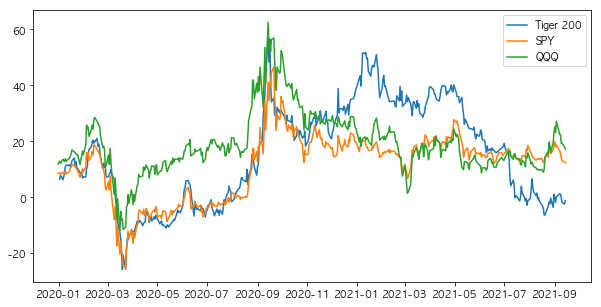

In [169]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    if (k in [""]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS", "064350.KS", "102110.KS", "SPY", "QQQ"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 차트 - 100기준 수익률

2021-09-15 15:33:25,655 - DEBUG - update_title_pos
2021-09-15 15:33:25,725 - DEBUG - update_title_pos
2021-09-15 15:33:25,763 - DEBUG - update_title_pos
2021-09-15 15:33:25,785 - DEBUG - update_title_pos


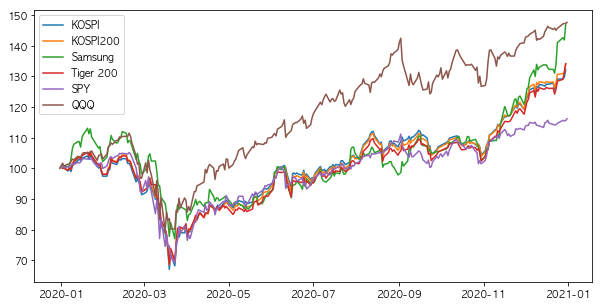

In [43]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS", "064350.KS", "102110.KS", "SPY", "QQQ"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 차트 - 개별 종목 가격, 이동평균

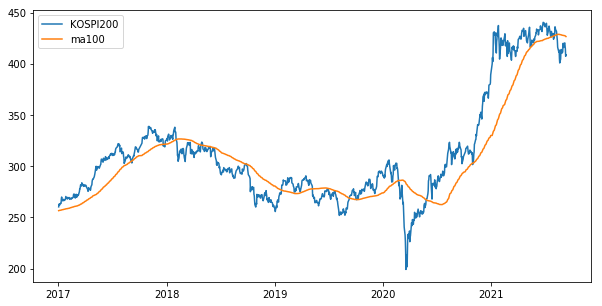

In [44]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_dict[code]['data']
subplot.plot(ticker_data['Close'], label=std_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

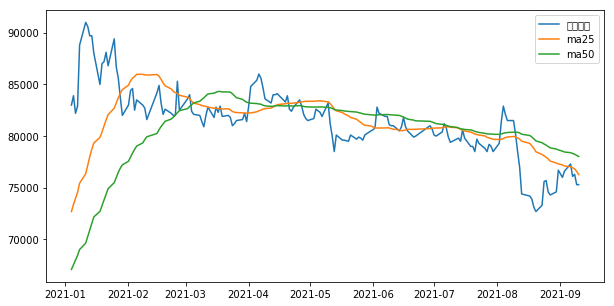

In [74]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,2185,2130,2135,2180,131658,2180,2115,2700,-19.259259,100.000000,2111.0,2144.8,2209.3,2191.4
2020-01-03,2190,2145,2160,2160,107168,2160,2180,2700,-20.000000,99.082569,2121.0,2143.2,2206.8,2192.1


# 자산 관리 - 종목 매수, 매도

In [5]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_cache.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.buy_atr20 = 0
        self.highest_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price, atr20):
        self.count += count
        self.buy_price = price
        self.buy_atr20 = atr20
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        if (price > self.highest_price):
            self.highest_price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price, atr20):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price, atr20)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        cash_percent = round(self.cash/self.total*100,2)
        log.info("Asset.display(): total=%d cash=%d cash_percent=%.2f", self.total, self.cash, cash_percent)
        for k, v in self.stocks.items():
            log.info("     code=%s stock_name=%s count=%d price=%d amount=%d highest_price=%d profit_percent=%.2f", \
                     v.code, v.stock_name, v.count, v.price, v.amount, v.highest_price, v.get_profit_percent())
            #print("    ", "code=", v.code, "stock_name=", v.stock_name, \
            #      "count=", v.count, "price=", v.price, "amount=", v.amount, \
            #      "highest_price=", v.highest_price, \
            #      "profit_percent=", v.get_profit_percent())


In [6]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000, 1000)
asset.apply(code, 80000)
#asset.sell(code, 90000)
asset.display()

2021-09-15 19:06:09,104 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-09-15 19:06:09,104 - INFO - NumExpr defaulting to 8 threads.
2021-09-15 19:06:09,115 - INFO - Asset.display(): total=10100000 cash=9300000 cash_percent=92.08
2021-09-15 19:06:09,116 - INFO -      code=005930.KS stock_name=삼성전자 count=10 price=80000 amount=800000 highest_price=80000 profit_percent=14.29


# 종목 이벤트 이력

In [7]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_cache.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [8]:
def make_batch_data(idx):
    batch_data = pd.DataFrame()
    for k, v in ticker_dict.items():
        if (idx in v['data'].index):
            print("k=", k, "exist yes")
            copy = v['data'].loc[idx].copy()
            copy['code'] = k
            batch_data = batch_data.append(copy)
        else:
            print("k=", k, "exist no")
    return batch_data
#ticker_data = ticker_dict['005930.KS']['data']

batch_data = make_batch_data("2020-01-02")
batch_data.head(10)

""


In [37]:
class LTHM: # Long Trend High Momentum
    def __init__(self, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_STOCK_PRICE = 6000 # 6천원 이상
        self.ATR_MULTIPLY = 2 # stop loss=ATR*ATR_MULTIPLY
        self.PROFIT_RESERVE_PERCENT = 15
        
        self.STOP_LOSS_PERCENT = 1
        self.MIN_PREV_RATE180 = 0
        self.MAX_BUY_PER_DAY = 2
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.stock_history_store = StockHistoryStore()
        self.action_histories = [ ]
        
    def set_asset(self, asset):
        self.asset = asset
    def set_data(self, data):
        self.data = data
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_dict.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_STOCK_PRICE) &\
            (batch_data['ma25'] > batch_data['ma50']) &\
            (batch_data['prev_rate180'] >= 0)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = ticker_dict['005930.KS']['data'] # idx 가져오기 위해 삼성전자 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def backtest(self, year):
        start_idx = f"{year}-01-01"
        end_idx = f"{year}-12-31"
        ticker_data = ticker_dict['005930.KS']['data']
        ticker_data = ticker_data[start_idx:end_idx]
        for idx, row in ticker_data.iterrows():
            #log.debug("LTHM.backtest(): idx=%s", idx)
            self.apply(idx)

        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        buy_per_day = 0
        if (self.is_ks200_satisfied(idx)):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #print("LTHM.apply():", "idx=", idx, "batch_data_len=", len(batch_data))
            for idx, row in batch_data.iterrows():
                if (self.get_available_position_percent() < self.MAX_POSITION_PERCENT/2): # 5% 이하면 break
                    break
#                if (not self.is_available_position()): # 10% 이하면 break
#                    break
                code = row['code']
                if (self.apply_stock_buy(code, idx, row)):
                    buy_per_day += 1
                    if (buy_per_day >= self.MAX_BUY_PER_DAY):
                        break
            
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                self.apply_stock_sell(code, idx, row)
            else:
                print(f"LTHM.apply(): ticker_data index not found, ignored: idx={idx} code={code}")

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
       
    def apply_stock_buy(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        self.asset.apply(code, price)
        
        # Check buy
        if (not self.asset.is_stock(code) and \
            self.is_uptrend(stock_history, idx, row)):
            count = self.get_buy_count(price, atr20)
            if (count > 0):
                action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, "stock_name": stock_history.name, "count": count, "price": price, \
                         "prev_rate180": row['prev_rate180']}
                log.info("action=%s", str(action))
                self.asset.buy(code, count, price, atr20)
                self.asset.display()
                self.action_histories.append(action)
                return True
        return False
                
    def apply_stock_sell(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        self.asset.apply(code, price)
                
        # Check sell
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            if (self.is_stop_loss(stock, row) or \
               self.is_profit_reserve(stock, row)):
                self.asset.sell(code, price)
                action = {"name": "sell", \
                          "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, \
                          "stock_name": stock_history.name, \
                          "count": count, \
                          "price": price, \
                          "buy_price": stock.buy_price, \
                          "profit_percent": stock.get_profit_percent()}
                log.info("action=%s", str(action))
                self.asset.display()
                self.action_histories.append(action)
                return True
        return False

    def is_ks200_satisfied(self, idx):
        code = "KS200"
        ticker_data = std_dict[code]['data']
        row = ticker_data.loc[idx]
        if (row['Close'] > row['ma100']):
            return True
        return False
    
    # 총자산 대비 위험 비율
    def get_buy_count(self, price, atr20):
        #if (not self.is_available_position()):
        #    return 0
        position_limit = self.get_position_limit() # 포지션 최대 금액
        position_risk_amount = math.floor(self.asset.total * self.RISK_PERCENT / 100) # 포지션 위험 부담 금액
        stop_loss_amount = atr20*self.ATR_MULTIPLY # 주당 위험 부담 금액
        
        # buy count(포지션 크기) 계산
        buy_count = math.floor(position_risk_amount / stop_loss_amount)
        position_amount = buy_count * price
        if (position_amount > position_limit):
            position_amount = position_limit
            buy_count = math.floor(position_amount / price)
            
        # cash limit
        cash_limit = self.get_cash_limit()
        if (position_amount > cash_limit):
            position_amount = cash_limit
            buy_count = math.floor(position_amount / price)
        #if (position_amount > self.asset.cash):
        #    buy_count = 0
        log.debug("LTHM.get_buy_count(): buy_count=%d position_amount=%d total=%d cash=%d position_limit=%d cash_limit=%d", \
                  buy_count, position_amount, self.asset.total, self.asset.cash, position_limit, cash_limit)
        #print(f"LTHM.get_buy_count(): buy_count={buy_count} position_amount={position_amount} \
        #    total={self.asset.total} cash={self.asset.cash} position_limit={position_limit} cash_limit={cash_limit}")
        return buy_count
    
    # 총자산 대비 금액 비율
    def get_buy_count_old(self, price):       
        if (not self.is_available_position()):
            return 0
        position_cash = self.asset.cash / available_position_count
        position_limit = self.asset.total * self.MAX_POSITION_PERCENT / 100
        print("LTHM.get_buy_count():", "position_cash=", position_cash, "position_limit=", position_limit)
        if (position_cash > position_limit):
            position_cash = position_limit
        return math.floor(position_cash / price)
    
    def get_position_limit(self):
        return math.floor(self.asset.total*self.MAX_POSITION_PERCENT/100)
    
    def get_cash_limit(self):
        one_percent_amount = self.asset.total*0.01
        if (self.asset.cash <= one_percent_amount):
            return 0
        return self.asset.cash - one_percent_amount
    
    def get_available_position_percent(self):
        return self.asset.cash/self.asset.total*100
    
    def is_available_position(self):
        if (self.asset.cash/self.asset.total*100 >= self.MAX_POSITION_PERCENT):
            return True
        return False
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def is_stop_loss(self, stock, row):
        price = row['Close']
        #if (price < stock.buy_price and ((stock.buy_price-price)/stock.buy_price*100 >= self.STOP_LOSS_PERCENT)):
        #    print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
        #          "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
        #    return True
        if (price < stock.buy_price and ((stock.buy_price-price) > stock.buy_atr20*self.ATR_MULTIPLY)):
            print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
            return True
        return False

    def is_profit_reserve(self, stock, row):
        price = row['Close']
        if (price < stock.highest_price*(1-self.PROFIT_RESERVE_PERCENT/100)):
            print("LTHM.is_profit_reserve():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "highest_price=", stock.highest_price)
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


## 시스템 - max_percent=33

In [ ]:
system = LTHM(max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

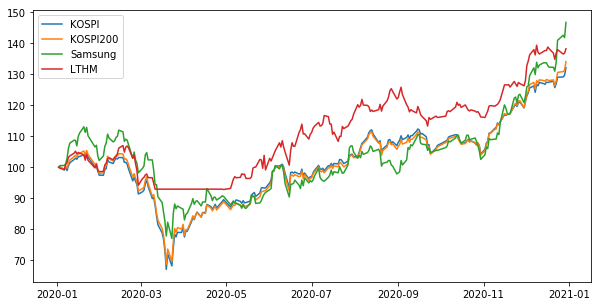

In [31]:
show_chart()

## 시스템 - max_percent=10

In [38]:
reset_dict()
system = LTHM(max_percent=10)

for year in range(2020,2021):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

2021-09-15 19:26:24,420 - DEBUG - LTHM.get_buy_count(): buy_count=181 position_amount=10000000 total=100000000 cash=100000000 position_limit=10000000 cash_limit=99000000
2021-09-15 19:26:24,421 - INFO - action={'name': 'buy', 'idx': '2020-01-02', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 181, 'price': 55200.0, 'prev_rate180': 19.35}
2021-09-15 19:26:24,442 - INFO - Asset.display(): total=100000000 cash=90008800 cash_percent=90.01
2021-09-15 19:26:24,443 - INFO -      code=005930.KS stock_name=삼성전자 count=181 price=55200 amount=9991200 highest_price=55200 profit_percent=0.00
2021-09-15 19:26:24,683 - DEBUG - LTHM.get_buy_count(): buy_count=330 position_amount=10086880 total=100868800 cash=90008800 position_limit=10086880 cash_limit=89000112
2021-09-15 19:26:24,684 - INFO - action={'name': 'buy', 'idx': '2020-01-14', 'code': '102110.KS', 'stock_name': 'TIGER 200', 'count': 330, 'price': 30555.0, 'prev_rate180': 11.62}
2021-09-15 19:26:24,707 - INFO - Asset.display(): total=10086

LTHM.is_stop_loss(): code= 102110.KS stock_name= TIGER 200 buy_price= 30555.0 price= 29725.0 buy_atr20= 301.5
LTHM.is_stop_loss(): code= 102110.KS stock_name= TIGER 200 buy_price= 29835.0 price= 28885.0 buy_atr20= 355.0


2021-09-15 19:26:25,143 - INFO - Asset.display(): total=99768900 cash=79446925 cash_percent=79.63
2021-09-15 19:26:25,144 - INFO -      code=005930.KS stock_name=삼성전자 count=181 price=57200 amount=10353200 highest_price=62400 profit_percent=3.62
2021-09-15 19:26:25,144 - INFO -      code=102110.KS stock_name=TIGER 200 count=345 price=28895 amount=9968775 highest_price=28895 profit_percent=0.00
2021-09-15 19:26:25,610 - INFO - action={'name': 'sell', 'idx': '2020-02-27', 'code': '102110.KS', 'stock_name': 'TIGER 200', 'count': 345, 'price': 28095.0, 'buy_price': 28895.0, 'profit_percent': -2.77}
2021-09-15 19:26:25,610 - INFO - Asset.display(): total=99257600 cash=89139700 cash_percent=89.81
2021-09-15 19:26:25,611 - INFO -      code=005930.KS stock_name=삼성전자 count=181 price=55900 amount=10117900 highest_price=62400 profit_percent=1.27
2021-09-15 19:26:25,631 - INFO - action={'name': 'sell', 'idx': '2020-03-11', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 181, 'price': 52100.0, '

LTHM.is_stop_loss(): code= 102110.KS stock_name= TIGER 200 buy_price= 28895.0 price= 28095.0 buy_atr20= 382.0
LTHM.is_stop_loss(): code= 005930.KS stock_name= 삼성전자 buy_price= 55200.0 price= 52100.0 buy_atr20= 985.0


2021-09-15 19:26:25,859 - DEBUG - LTHM.get_buy_count(): buy_count=191 position_amount=9856980 total=98569800 cash=98569800 position_limit=9856980 cash_limit=97584102
2021-09-15 19:26:25,860 - INFO - action={'name': 'buy', 'idx': '2020-06-02', 'code': '005930.KS', 'stock_name': '삼성전자', 'count': 191, 'price': 51400.0, 'prev_rate180': 2.19}
2021-09-15 19:26:25,881 - INFO - Asset.display(): total=98569800 cash=88752400 cash_percent=90.04
2021-09-15 19:26:25,881 - INFO -      code=005930.KS stock_name=삼성전자 count=191 price=51400 amount=9817400 highest_price=51400 profit_percent=0.00
2021-09-15 19:26:27,983 - DEBUG - LTHM.get_buy_count(): buy_count=330 position_amount=9994500 total=99945000 cash=88752400 position_limit=9994500 cash_limit=87752950
2021-09-15 19:26:27,984 - INFO - action={'name': 'buy', 'idx': '2020-09-24', 'code': '102110.KS', 'stock_name': 'TIGER 200', 'count': 330, 'price': 30210.0, 'prev_rate180': 25.04}
2021-09-15 19:26:28,003 - INFO - Asset.display(): total=99945000 cash=

2021-09-15 19:24:03,060 - DEBUG - update_title_pos
2021-09-15 19:24:03,118 - DEBUG - update_title_pos
2021-09-15 19:24:03,154 - DEBUG - update_title_pos
2021-09-15 19:24:03,175 - DEBUG - update_title_pos


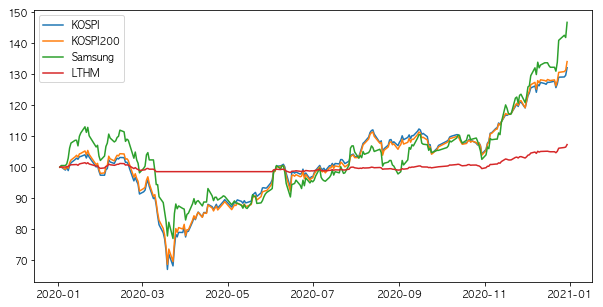

In [34]:
show_chart()

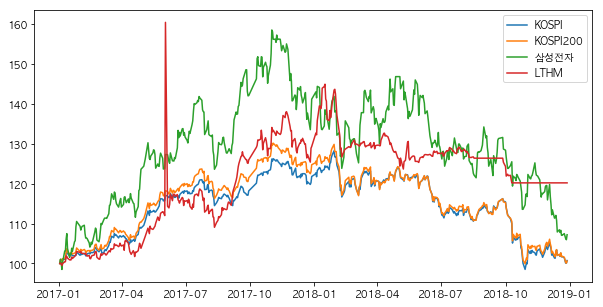

In [127]:
# 5atr stop loss, 15% preserve, 2 buy per day
show_chart()

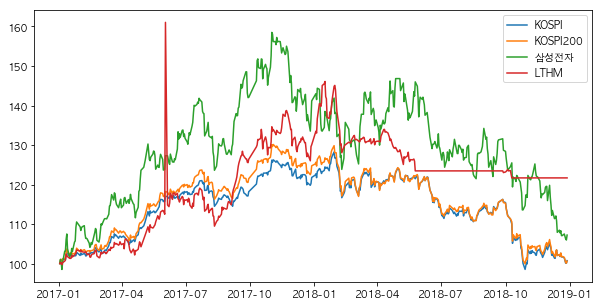

In [121]:
# 5atr stop loss, 15% preserve, 1 buy per day
show_chart()

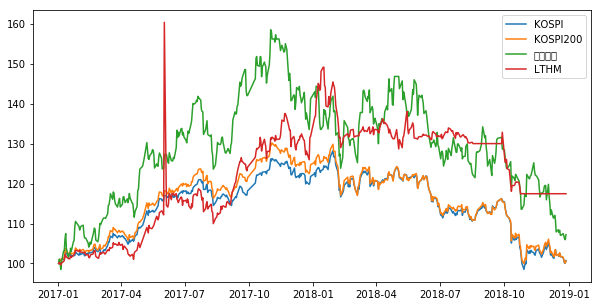

In [113]:
# 5atr stop loss, 15% preserve
show_chart()

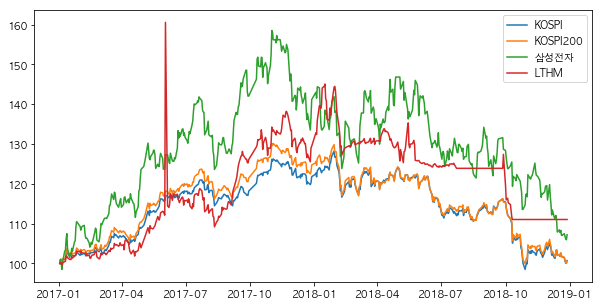

In [118]:
# 2atr stop loss, 15% perserve
show_chart()

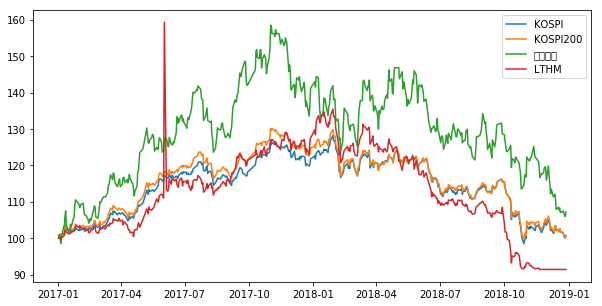

In [108]:
# 5atr stop loss, 25% preserve
show_chart()

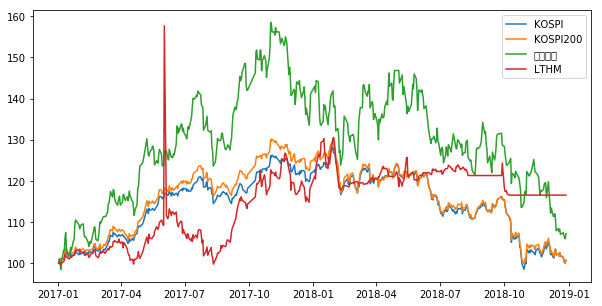

In [98]:
# 3% stop loss, 10% preserve
show_chart()

In [112]:
for year in range(2018,2019):
    load_std_dict(std_dict, year)
    load_ticker_dict(ticker_dict, year)
    system.backtest(year)

LTHM.get_buy_count(): buy_count=77 position_amount=13551632             total=135516322.4375 cash=34401606.4375 position_limit=13551632 cash_limit=33046443.213125
action: {'name': 'buy', 'idx': '2018-01-03', 'code': '035420.KS', 'stock_name': 'NAVER', 'count': 77, 'price': 174200.0, 'prev_rate180': 1.1614401858304297}
Asset.display(): total=135516322.4375 cash=20988206.4375 cash_percent=15.49
     code= 005490.KS stock_name= POSCO count= 38 price= 357500.0 amount= 13585000.0 highest_price= 357500.0 profit_percent= 37.24
     code= 051910.KS stock_name= LG화학 count= 38 price= 409500.0 amount= 15561000.0 highest_price= 423500.0 profit_percent= 51.95
     code= 009150.KS stock_name= 삼성전기 count= 103 price= 100000.0 amount= 10300000.0 highest_price= 112000.0 profit_percent= 0.7
     code= 068270.KS stock_name= 셀트리온 count= 104 price= 225829.0 amount= 23486216.0 highest_price= 225829.0 profit_percent= 132.13
     code= 066570.KS stock_name= LG전자 count= 137 price= 109500.0 amount= 15001500.0 hi

LTHM.get_buy_count(): buy_count=178 position_amount=5980800.0             total=139418514.4375 cash=41067114.4375 position_limit=13941851 cash_limit=39672929.293125
action: {'name': 'buy', 'idx': '2018-01-22', 'code': '009420.KS', 'stock_name': '한올바이오파마', 'count': 178, 'price': 33600.0, 'prev_rate180': 177.68595041322314}
Asset.display(): total=139418514.4375 cash=35086314.4375 cash_percent=25.17
     code= 005490.KS stock_name= POSCO count= 38 price= 385500.0 amount= 14649000.0 highest_price= 386500.0 profit_percent= 47.98
     code= 051910.KS stock_name= LG화학 count= 38 price= 423500.0 amount= 16093000.0 highest_price= 437000.0 profit_percent= 57.14
     code= 009150.KS stock_name= 삼성전기 count= 103 price= 101500.0 amount= 10454500.0 highest_price= 112000.0 profit_percent= 2.22
     code= 066570.KS stock_name= LG전자 count= 137 price= 107500.0 amount= 14727500.0 highest_price= 111000.0 profit_percent= 26.03
     code= 035420.KS stock_name= NAVER count= 77 price= 176200.0 amount= 13567400.

LTHM.get_buy_count(): buy_count=340 position_amount=4607000.0             total=131175063.4375 cash=106058063.4375 position_limit=13117506 cash_limit=104746312.803125
action: {'name': 'buy', 'idx': '2018-04-27', 'code': '006490.KS', 'stock_name': '인스코비', 'count': 340, 'price': 13550.0, 'prev_rate180': 642.4657534246576}
Asset.display(): total=131175063.4375 cash=101451063.4375 cash_percent=77.34
     code= 066570.KS stock_name= LG전자 count= 137 price= 101000.0 amount= 13837000.0 highest_price= 113500.0 profit_percent= 18.41
     code= 018260.KS stock_name= 삼성에스디에스 count= 47 price= 240000.0 amount= 11280000.0 highest_price= 260000.0 profit_percent= -7.16
     code= 006490.KS stock_name= 인스코비 count= 340 price= 13550.0 amount= 4607000.0 highest_price= 13550.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=147 position_amount=2844450.0             total=131175063.4375 cash=101451063.4375 position_limit=13117506 cash_limit=100139312.803125
action: {'name': 'buy', 'idx': '2018-04-27', 'c

LTHM.is_profit_reserve(): code= 207940.KS stock_name= 삼성바이오로직스 buy_price= 506000.0 price= 404000.0 highest_price= 506000.0
action: {'name': 'sell', 'idx': '2018-05-02', 'code': '207940.KS', 'stock_name': '삼성바이오로직스', 'count': 22, 'price': 404000.0, 'buy_price': 506000.0, 'profit_percent': -20.16}
Asset.display(): total=131355652.203125 cash=45450713.4375 cash_percent=34.6
     code= 066570.KS stock_name= LG전자 count= 137 price= 102000.0 amount= 13974000.0 highest_price= 113500.0 profit_percent= 19.58
     code= 018260.KS stock_name= 삼성에스디에스 count= 47 price= 245000.0 amount= 11515000.0 highest_price= 260000.0 profit_percent= -5.22
     code= 006490.KS stock_name= 인스코비 count= 340 price= 12700.0 amount= 4318000.0 highest_price= 13550.0 profit_percent= -6.27
     code= 033180.KS stock_name= KH 필룩스 count= 147 price= 17100.0 amount= 2513700.0 highest_price= 19350.0 profit_percent= -11.63
     code= 005690.KS stock_name= 파미셀 count= 210 price= 17750.0 amount= 3727500.0 highest_price= 18700.0 pro

LTHM.is_profit_reserve(): code= 000660.KS stock_name= SK하이닉스 buy_price= 87100.0 price= 80500.0 highest_price= 95300.0
action: {'name': 'sell', 'idx': '2018-07-25', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 150, 'price': 80500.0, 'buy_price': 87100.0, 'profit_percent': -7.58}
Asset.display(): total=132251675.25390625 cash=115292175.25390625 cash_percent=87.18
     code= 009150.KS stock_name= 삼성전기 count= 107 price= 158500.0 amount= 16959500.0 highest_price= 162500.0 profit_percent= 30.45
LTHM.is_profit_reserve(): code= 009150.KS stock_name= 삼성전기 buy_price= 121500.0 price= 137500.0 highest_price= 163000.0
action: {'name': 'sell', 'idx': '2018-08-17', 'code': '009150.KS', 'stock_name': '삼성전기', 'count': 107, 'price': 137500.0, 'buy_price': 121500.0, 'profit_percent': 13.17}
Asset.display(): total=130004675.25390625 cash=130004675.25390625 cash_percent=100.0
LTHM.get_buy_count(): buy_count=393 position_amount=12418800.0             total=130004675.25390625 cash=130004675.25390625

LTHM.is_profit_reserve(): code= 017800.KS stock_name= 현대엘리베이 buy_price= 77000.0 price= 75333.296875 highest_price= 111500.0
action: {'name': 'sell', 'idx': '2018-10-01', 'code': '017800.KS', 'stock_name': '현대엘리베이', 'count': 127, 'price': 75333.296875, 'buy_price': 77000.0, 'profit_percent': -2.16}
Asset.display(): total=127981603.95703125 cash=54648053.95703125 cash_percent=42.7
     code= 064350.KS stock_name= 현대로템 count= 393 price= 30900.0 amount= 12143700.0 highest_price= 31600.0 profit_percent= -2.22
     code= 002210.KS stock_name= 동성제약 count= 135 price= 31750.0 amount= 4286250.0 highest_price= 37200.0 profit_percent= -14.65
     code= 000720.KS stock_name= 현대건설 count= 192 price= 67800.0 amount= 13017600.0 highest_price= 67800.0 profit_percent= 0.59
     code= 009150.KS stock_name= 삼성전기 count= 85 price= 139000.0 amount= 11815000.0 highest_price= 142000.0 profit_percent= -2.11
     code= 006400.KS stock_name= 삼성SDI count= 49 price= 258500.0 amount= 12666500.0 highest_price= 261000.

In [92]:
asset=system.asset
system_data=system.data

In [94]:
system = LTHM(max_percent=10)
system.set_asset(asset)
system.set_data(system_data)